## Importações

In [41]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import logging

## Leitura

In [42]:
spark = SparkSession.builder \
    .appName("AnaliseENEM") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

leitura = spark.read.option("header", "true") \
               .option("sep", ";") \
               .option("encoding", "ISO-8859-1") \
               .option("inferSchema", "true") \
               .csv("data_raw/MICRODADOS_ENEM_2021.csv")

logging.getLogger("py4j").setLevel(logging.ERROR)
logging.getLogger("pyspark").setLevel(logging.ERROR)

## Verificação da qualidade dos dados na camada bronze:

###  1. Escolha estados

Tendo em vista o tamanho exagerado da base de dados por decisão do grupo em união com o professor foi tomada a decisão de trazer dados para escolher um estado para fazer análise, os gráficos nessa primiera parte estão de acordo com essa proposta.

#### 1.1 Gráfico de pizza de estados com mais incritos e mais colunas preenchidas

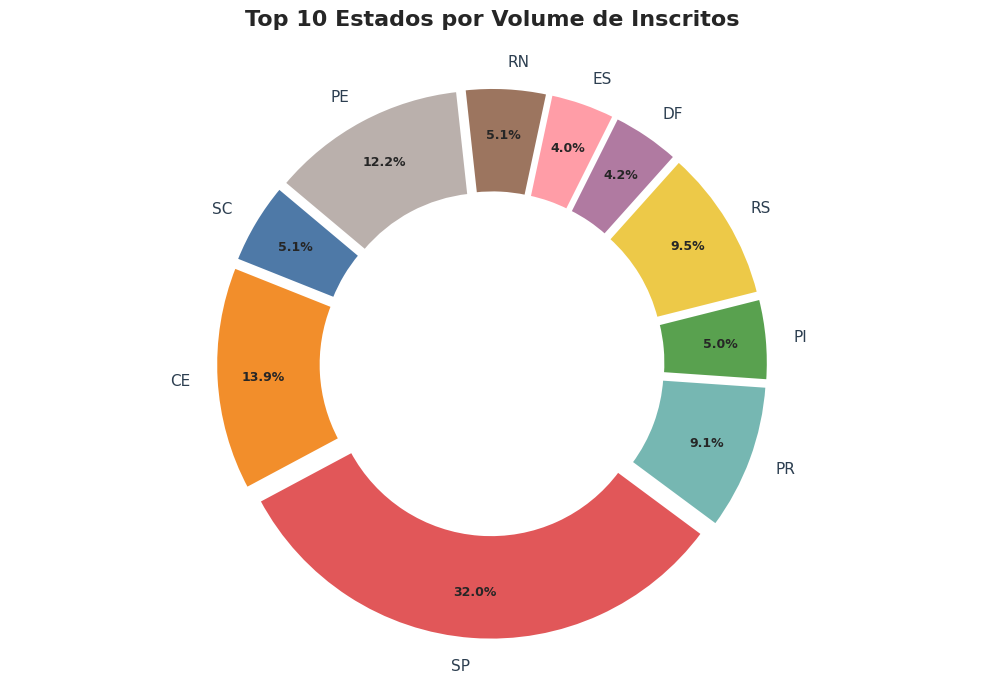

In [ ]:
coluna_uf = 'SG_UF_PROVA' 

colunas_analise = [c for c in leitura.columns if c != coluna_uf]
total_colunas = len(colunas_analise)
verificacao_UF = leitura.groupBy(coluna_uf).agg(
    F.count("*").alias("Qtd_Inscritos"),
    *[F.count(c).alias(c) for c in colunas_analise]
)
analise_final = verificacao_UF.withColumn(
    "Total_Celulas_Preenchidas", 
    sum(F.col(c) for c in colunas_analise)
).withColumn(
    "Perc_Preenchimento",
    F.round((F.col("Total_Celulas_Preenchidas") / (F.col("Qtd_Inscritos") * total_colunas)) * 100, 2)
)
relatorio_estados = analise_final.select(
    F.col(coluna_uf).alias("Estado"), 
    F.col("Qtd_Inscritos").alias("Inscritos"), 
    F.col("Perc_Preenchimento").alias("% Preenchido")
).orderBy(F.desc("% Preenchido"))

dados_locais = relatorio_estados.limit(10).collect()

estados = [row['Estado'] for row in dados_locais]
inscritos = [row['Inscritos'] for row in dados_locais]

cores = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', 
         '#EDC948', '#B07AA1', '#FF9DA7', '#9C755F', '#BAB0AC']

fig, ax = plt.subplots(figsize=(10, 7))

fatias, textos, porcentagens = ax.pie(
    inscritos, 
    labels=estados, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=cores,
    pctdistance=0.82, 
    explode=[0.05] * len(estados), 
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 2}
)

plt.setp(porcentagens, size=9, weight="bold")
plt.setp(textos, size=11, color="#2c3e50")

ax.set_title('Top 10 Estados por Volume de Inscritos', fontsize=16, pad=25, weight='bold')
ax.axis('equal')  

plt.tight_layout()
plt.show()

#### 1.2 Gráfico de colunas menos preenchidas entre os melhores estados

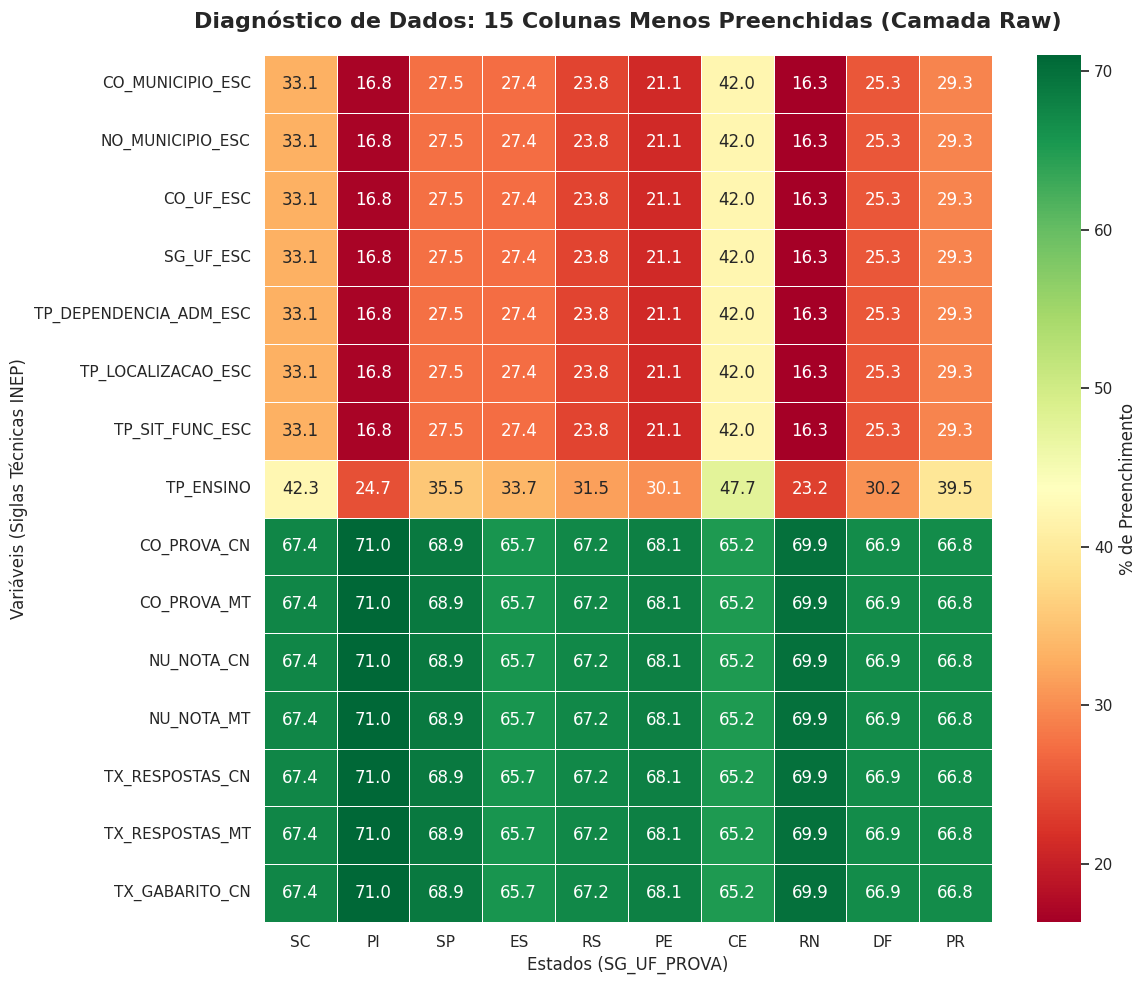

In [20]:
melhores_estados = [row['Estado'] for row in relatorio_estados.limit(10).collect()]
filtro_melhores_estados = leitura.filter(F.col("SG_UF_PROVA").isin(melhores_estados))

caminho_dicionario = 'data_raw/Dicionário_Microdados_Enem_2021.xlsx - MICRODADOS_ENEM_2021.csv'

coluna_dados = [c for c in leitura.columns if c != "SG_UF_PROVA"]
contagem_colunas = [F.count(c).alias(c) for c in coluna_dados]

analise_colunas = filtro_melhores_estados.groupBy("SG_UF_PROVA").agg(
    F.count('*').alias("Total_inscritos"),
    *contagem_colunas
)

colunas_pandas = analise_colunas.toPandas().set_index("SG_UF_PROVA")

for col in coluna_dados:
    colunas_pandas[col] = (colunas_pandas[col] / colunas_pandas["Total_inscritos"]) * 100

piores_colunas = colunas_pandas[coluna_dados].mean().nsmallest(15).index.tolist()

plot_piores_colunas = colunas_pandas[piores_colunas].T

plt.figure(figsize=(12, 10))
sns.set_theme(style="white")

ax = sns.heatmap(
    plot_piores_colunas, 
    annot=True, 
    fmt=".1f", 
    cmap="RdYlGn", 
    linewidths=.5,
    cbar_kws={'label': '% de Preenchimento'}
)

plt.title('Diagnóstico de Dados: 15 Colunas Menos Preenchidas (Camada Raw)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Estados (SG_UF_PROVA)', fontsize=12)
plt.ylabel('Variáveis (Siglas Técnicas INEP)', fontsize=12)

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Com os dois gráficos acima e tendo em vista o espaço amostral entre os estados, por decisão conjunta foi definido utilizar o estado de São Paulo, afinal o estado mais populoso do Brasil, ainda tem um bom nível de preenchiemnto e nas piores colunas a porcentagem não difere de maneira exorbitante se mostrando uma boa solução para utilização em nosso trabalho 

### 2. Análise de dados do estado escolhido

#### 2.1 Linhas preenchidas por coluna 

/tmp/ipykernel_58013/3959303540.py:17: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")


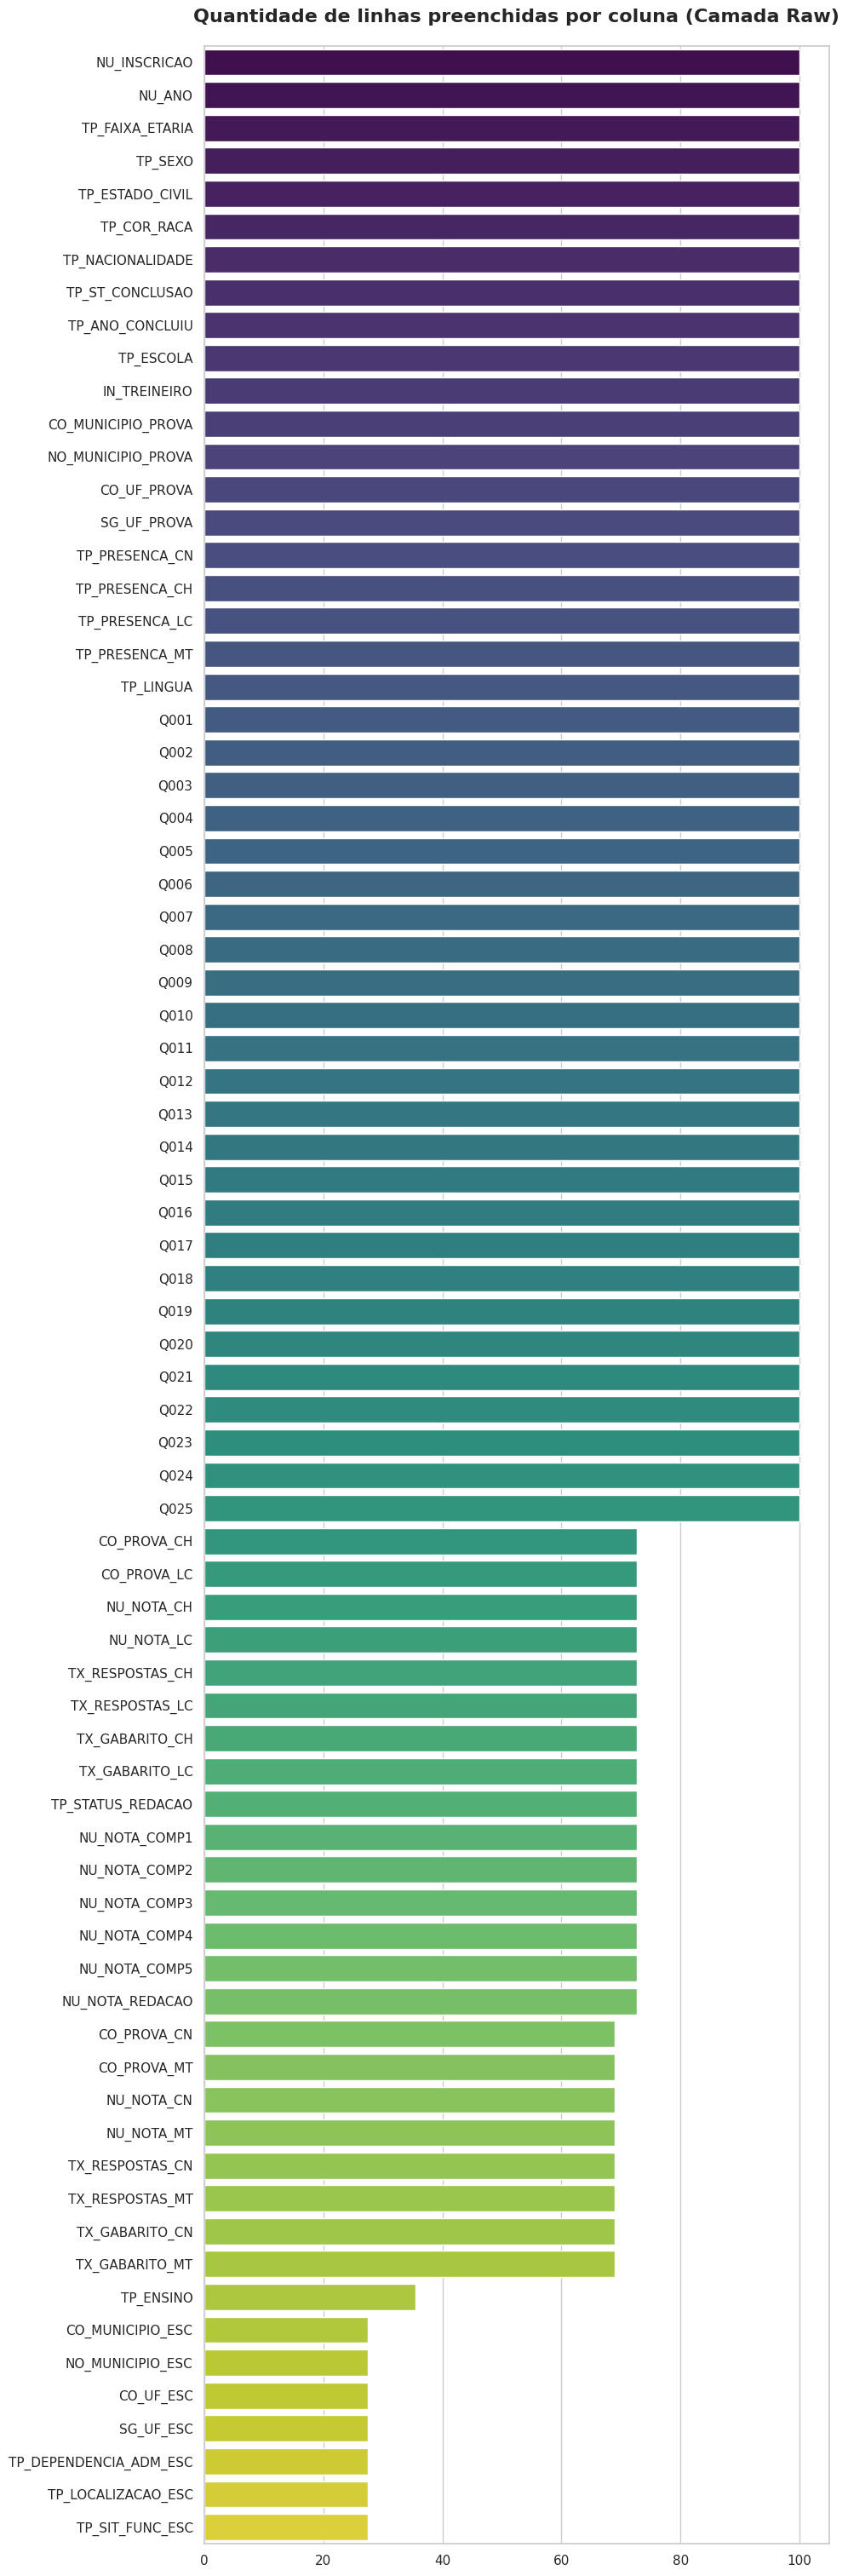

In [25]:
estado_SP = leitura.filter(F.col("SG_UF_PROVA") == "SP")

total_sp = estado_SP.count()

total_sp_nulos = estado_SP.agg(*[F.count(F.col(c)).alias(c) for c in estado_SP.columns]).collect()[0].asDict()

coluna_total_nulos = list(total_sp_nulos.keys())
percentual_coluna_nula = [(total_sp_nulos[c]/total_sp) * 100 for c in coluna_total_nulos]

dados_ordenados_completude = sorted(zip(coluna_total_nulos, percentual_coluna_nula), key=lambda x: x[1], reverse=True)

colunas_plot, valores_plot = zip(*dados_ordenados_completude)

plt.figure(figsize=(10, len(colunas_plot) * 0.4))
sns.set_theme(style="whitegrid")

sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")

plt.title('Quantidade de linhas preenchidas por coluna (Camada Raw)', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


#### 2.2 Linhas duplicadas 

In [22]:
total_linhas_unicas = estado_SP.count()

total_duplicados = estado_SP.count() - total_linhas_unicas

print(total_duplicados)

0


#### 2.3 Análise de Outliers nas notas do ENEM

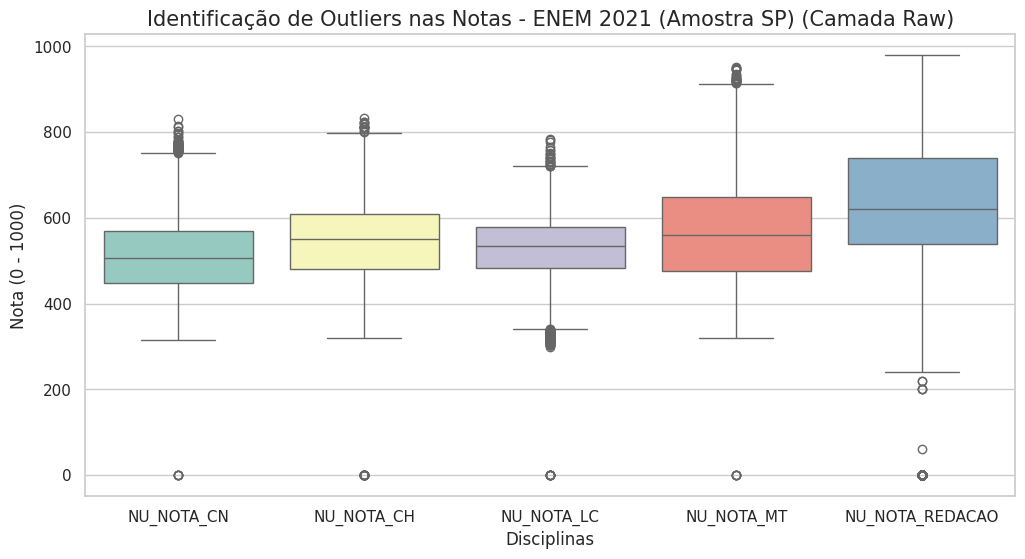

In [26]:
coluna_notas = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO"]
resumo_notas = estado_SP.select(coluna_notas).describe()

grafico_outlier = estado_SP.select(coluna_notas).sample(False, 0.05).toPandas()

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.boxplot(data=grafico_outlier, palette="Set3")

plt.title('Identificação de Outliers nas Notas - ENEM 2021 (Amostra SP) (Camada Raw)', fontsize=15)
plt.ylabel('Nota (0 - 1000)')
plt.xlabel('Disciplinas')
plt.show()

#### 2.4 Rating e dispersão

/tmp/ipykernel_58013/2671560794.py:15: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')


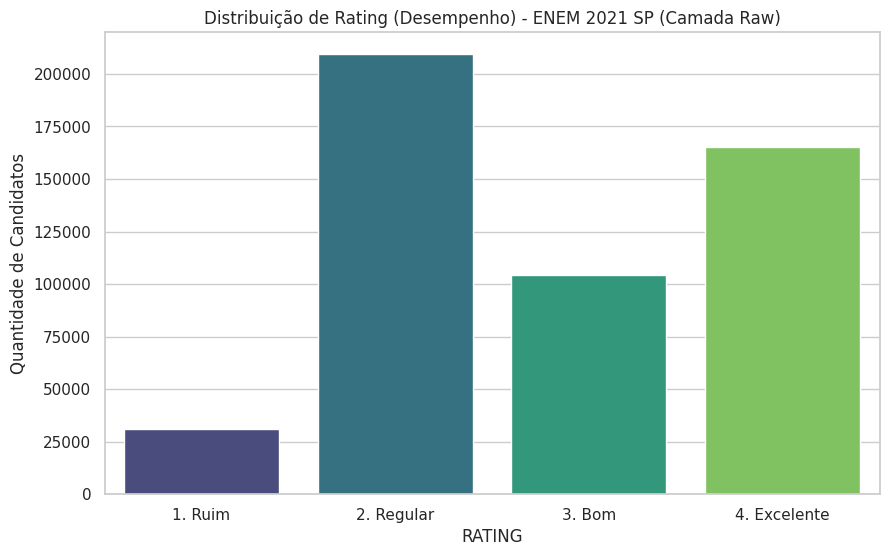

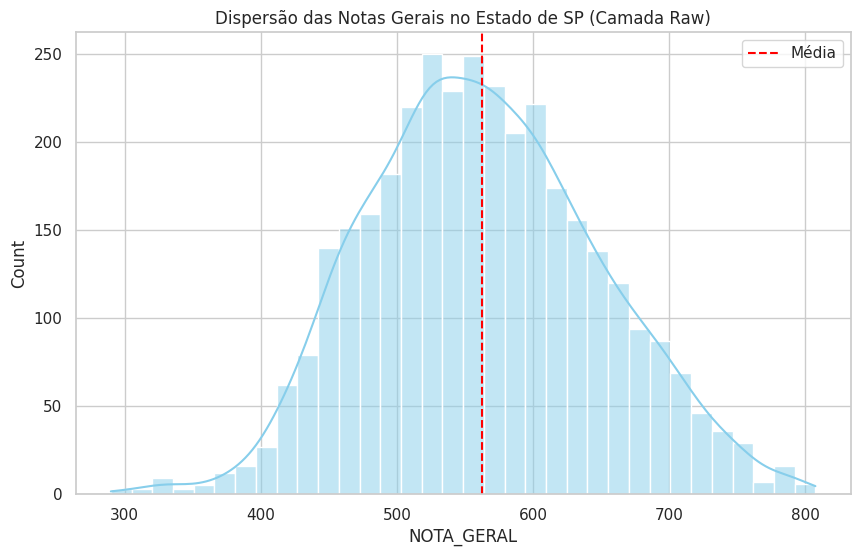

In [37]:
media_SP_notas = estado_SP.withColumn("NOTA_GERAL", sum([F.col(c) for c in coluna_notas]) / 5)

media_SP_notas = media_SP_notas.withColumn("RATING",
    F.when(F.col("NOTA_GERAL") < 450, "1. Ruim")
     .when(F.col("NOTA_GERAL") < 600, "2. Regular")
     .when(F.col("NOTA_GERAL") < 750, "3. Bom")
     .otherwise("4. Excelente")
)

status_dispersao = media_SP_notas.select("NOTA_GERAL").summary("mean", "stddev", "min", "25%", "50%", "75%", "max")

status_rating = media_SP_notas.groupBy("RATING").count().orderBy("RATING").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=status_rating, x='RATING', y='count', palette='viridis')
plt.title('Distribuição de Rating (Desempenho) - ENEM 2021 SP (Camada Raw)')
plt.ylabel('Quantidade de Candidatos')
plt.show()

amostra_notas = media_SP_notas.select("NOTA_GERAL").sample(False, 0.01).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(amostra_notas['NOTA_GERAL'], kde=True, color='skyblue')
plt.axvline(amostra_notas['NOTA_GERAL'].mean(), color='red', linestyle='--', label='Média')
plt.title('Dispersão das Notas Gerais no Estado de SP (Camada Raw)')
plt.legend()
plt.show()

#### 2.5 Outlier da idade dos estudantes do ENEM

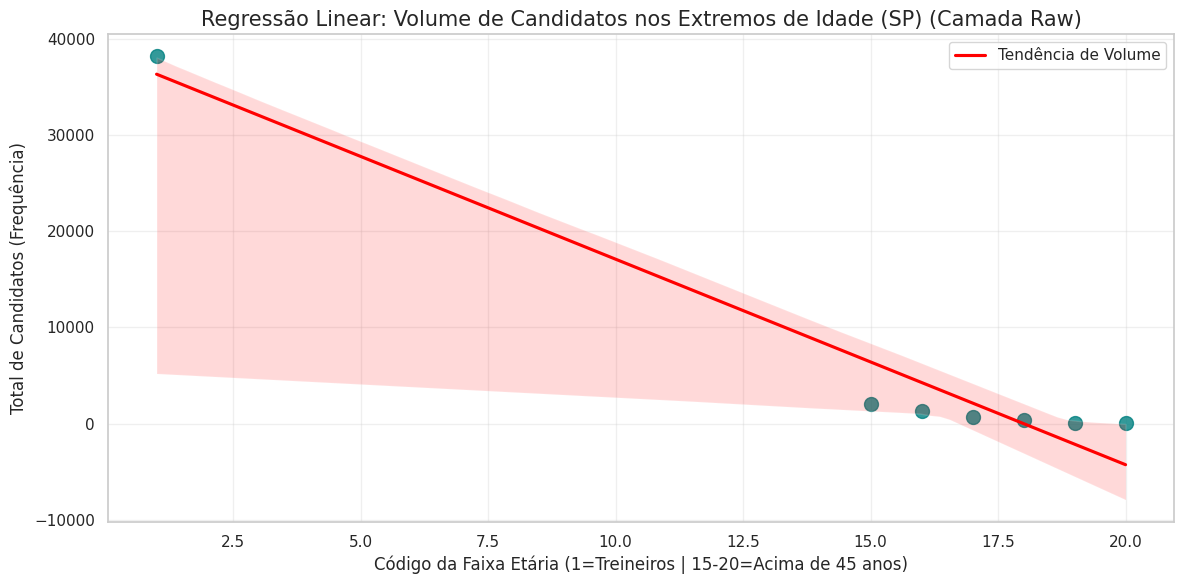

In [46]:
faixa_etaria_estudantes = leitura.filter(F.col("SG_UF_PROVA") == "SP") \
    .select("TP_FAIXA_ETARIA", "NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO") \
    .dropna()

outlier_idade = faixa_etaria_estudantes.filter((F.col("TP_FAIXA_ETARIA") == 1) | (F.col("TP_FAIXA_ETARIA") >= 15))

distribuicao_extremos = outlier_idade.groupBy("TP_FAIXA_ETARIA").count().orderBy("TP_FAIXA_ETARIA").toPandas()

plt.figure(figsize=(12, 6))

sns.regplot(
    data=distribuicao_extremos, 
    x="TP_FAIXA_ETARIA", 
    y="count", 
    color="teal",
    line_kws={"color": "red", "label": "Tendência de Volume"},
    scatter_kws={"s": 100}
)

plt.title('Regressão Linear: Volume de Candidatos nos Extremos de Idade (SP) (Camada Raw)', fontsize=15)
plt.xlabel('Código da Faixa Etária (1=Treineiros | 15-20=Acima de 45 anos)', fontsize=12)
plt.ylabel('Total de Candidatos (Frequência)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()